# Install detectron2

Installing Detectron2 and some other niggas. (Don't skip it)

In [ ]:
# install dependencies: 
! pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
! gcc --version
! pip install tensorboard
# opencv is pre-installed on colab
# Install decompression tool
! sudo apt install lrzip cpio

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
lrzip is already the newest version (0.631-1).
cpio is already the newest version (2.12+dfsg-6ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# # Update all pip packages
# %%bash
# pip list --outdated --format=freeze | grep -v "^\-e" | cut -d = -f 1 | xargs -n1 pip install --user -U

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
# Used later for flushing the gpu memory
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil psutil humanize
import psutil
import humanize
import GPUtil as GPU

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=9a2cc747c42773c9988904c79e13b96e9719cad6e2cdf3d78d63e9f14d338bce
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
# Some basic setup:
import torch.autograd.profiler as profiler
from torch.utils.tensorboard import SummaryWriter

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import imageio
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Prepare the dataset

Data structure:

    /content
    ------/train_images/
    ------train_ocr.json
    ------/val_images/
    ------val_ocr.json

### Download the data from Google Drive

We will load the dataset from google drive and decompress it.

You need to login first.

In [ ]:
# Connect to Google drive
from google.colab import drive 


try:
  if not os.path.isdir("/mntDrive/My Drive"):
    drive.mount('/mntDrive') 
except:
  print('Directory could not be mounted. nigga wtf')
else:
  ! ls "/mntDrive/My Drive/OCR datasets"

Mounted at /mntDrive
 10v			       data14-v.cpio.lrz   final.json
 20v			       data15.cpio.lrz	   final-pretty.json
 40v			       data15-v.cpio.lrz   images
 5v			       data16-2.cpio.lrz   image_train.7z
 b_nazanin.ttf		       data16.cpio.lrz	   image_val.7z
 coco_instances_results.json   data4		   medaya-bbox
 data10-1.cpio.lrz	       data4.7z		  'suzuya test'
 data10.cpio.lrz	      'data6 (1).7z'	   train_data.7z
 data12-2.cpio.lrz	       data6.7z		   train_ocr_fixed_13.json
 data12.cpio.lrz	       data8-1.tar	   train_ocr.json.lrz
 data12-v-2.cpio.lrz	       data8-1.tar.lrz	   val_data.7z
 data12-v.cpio.lrz	       data8.7z		   val_ocr_edited.json
 data13.cpio.lrz	       data9-1.tar.lrz	   val_ocr_fixed_13.json
 data13-v.cpio.lrz	       data9-2.tar.lrz	   val_ocr.json
 data14.cpio.lrz	       data9.tar.lrz


Decompressing the data (I fucked up the names so there are some fixes too)

In [ ]:
! lrzip -d "/mntDrive/My Drive/OCR datasets/data16-2.cpio.lrz" -O .

Output filename is: ./data16-2.cpio
tcmalloc: large alloc 4551204864 bytes == 0x564a4d28e000 @  0x7f0ce21ac1e7 0x564a4c05a575 0x564a4c05b9c2 0x564a4c057135 0x7f0ce0bfcbf7 0x564a4c0580ca
Decompressing...

Average DeCompression Speed: 150.000MB/s
Output filename is: ./data16-2.cpio: [OK] - 157650432 bytes                                
Total time: 00:00:01.58


In [ ]:
! cpio -id < data16-2.cpio

cpio: data16-2.cpio not created: newer or same age version exists
307911 blocks


In [ ]:
%%bash

lrzip -d "/mntDrive/My Drive/OCR datasets/data15-v.cpio.lrz" -O .
cpio -id < data15-v.cpio

Output filename is: ./data15-v.cpio
Decompressing...
100%      32.51 /     32.51 MB
Average DeCompression Speed: 32.000MB/s
Output filename is: ./data15-v.cpio: [OK] - 34084864 bytes                                
Total time: 00:00:01.95


tcmalloc: large alloc 4551204864 bytes == 0x558791480000 @  0x7f130af0a1e7 0x55878f872575 0x55878f8739c2 0x55878f86f135 0x7f130995abf7 0x55878f8700ca
cpio: data15-v.cpio not created: newer or same age version exists
66572 blocks


In [ ]:
!ls

'=2.0.1'	 data16-2.cpio	 val_images
 data15-v.cpio	 sample_data	 val_ocr.json


In [ ]:
! ls train_images | wc -l
! ls val_images | wc -l

ls: cannot access 'train_images': No such file or directory
0


100,000 train images

10,000 validation images

### Reformatting the Data

####Define the dataset

First see how much of each letter we have.

In [ ]:
def sum_list(json_path):
    """Show how much of each letter we have."""
    char_list = {}
    with open(json_path) as f:
        x = json.load(f)
        for block in x:
            chars = block['parts']
            for i in chars:
                if i in char_list:
                    char_list[i] += 1
                else:
                    char_list[i] = 1
    char_list['sum'] = sum(char_list.values())
    return char_list

In [ ]:
harf = sum_list("/content/val_ocr.json")
print(harf)

{'ﭘ': 710, 'ﺪ': 682, 'ﺿ': 675, 'ﯼ': 722, 'ﺋ': 687, 'ﺦ': 679, 'ﻦ': 704, 'ﻛ': 735, 'ﭗ': 666, 'ﻍ': 742, 'ﻘ': 698, 'ﺎ': 650, 'ﻢ': 691, 'ﺶ': 686, 'ﻓ': 655, 'ﻊ': 668, 'ﻫ': 677, 'ﺢ': 683, 'ﻪ': 676, 'ﻬ': 713, 'ﻞ': 666, 'ﺰ': 647, 'لا': 668, 'ﻖ': 708, 'ﯾ': 692, 'ﻉ': 650, 'ﺛ': 675, 'ﺑ': 686, 'ﺷ': 659, 'ﻋ': 658, 'ﺬ': 709, 'ﻮ': 662, 'ﻧ': 689, 'ﮋ': 671, 'ﺞ': 703, 'ﻠ': 633, 'ﺐ': 696, 'ﻗ': 662, 'ﻆ': 667, 'ﺁ': 697, 'ﻒ': 696, 'ﺣ': 698, 'ﺲ': 689, 'ﺖ': 630, 'ﻌ': 682, 'ﻂ': 670, 'ﺮ': 665, 'ﻏ': 708, 'ﻚ': 687, 'ﻎ': 701, 'ﮓ': 655, 'ﻟ': 680, 'ﺧ': 727, 'ﮔ': 733, 'ﭼ': 719, 'ﻩ': 686, 'ﻐ': 697, 'ﺚ': 717, 'ﺺ': 660, 'ﺗ': 657, 'ﺻ': 629, 'ﺾ': 716, 'ﭻ': 725, 'ﺳ': 649, 'ﻣ': 679, 'ﺟ': 698, 'sum': 45150}


Now we will create a label map for when we convert the raw json to detectron's needed json.

In [ ]:
# Creating a label map for our labels
# old_horuf = ['ض', 'ص', 'ث', 'ق', 'ف', 'غ', 'ع', 'ه', 'خ', 'ح',
#          'ج', 'چ', 'ش', 'ی', 'ی', 'ب', 'ل', 'ا', 'ت', 'ن',
#          'م', 'ک', 'گ', 'ظ', 'ط', 'ز', 'ر', 'ذ', 'د', 'پ',
#          'و', 'ژ', 'لا', 'لله', 'ریال']

# train_horuf = ['ﺍ', 'ﺎ', 'ﺏ', 'ﺐ', 'ﺑ', 'ﺒ', 'ﺕ', 'ﺖ', 'ﺗ', 'ﺘ', 'ﺙ',
#                    'ﺚ', 'ﺛ', 'ﺜ', 'ﺝ', 'ﺞ', 'ﺟ', 'ﺠ', 'ﺡ', 'ﺢ', 'ﺣ', 'ﺤ',
#                    'ﺥ', 'ﺦ', 'ﺧ', 'ﺨ', 'ﺩ', 'ﺪ', 'ﺫ', 'ﺬ', 'ﺭ', 'ﺮ', 'ﺯ',
#                    'ﺰ', 'ﺱ', 'ﺲ', 'ﺳ', 'ﺴ', 'ﺵ', 'ﺶ', 'ﺷ', 'ﺸ', 'ﺹ', 'ﺺ',
#                    'ﺻ', 'ﺼ', 'ﺽ', 'ﺾ', 'ﺿ', 'ﻀ', 'ﻁ', 'ﻂ', 'ﻅ', 'ﻆ', 'ﻉ',
#                    'ﻊ', 'ﻋ', 'ﻌ', 'ﻍ', 'ﻎ', 'ﻏ', 'ﻐ', 'ﻑ', 'ﻒ', 'ﻓ', 'ﻔ',
#                    'ﻕ', 'ﻖ', 'ﻗ', 'ﻘ', 'ﮎ', 'ﻚ', 'ﻛ', 'ﻜ', 'ﻝ', 'ﻞ', 'ﻟ',
#                    'ﻠ', 'ﻡ', 'ﻢ', 'ﻣ', 'ﻤ', 'ﻥ', 'ﻦ', 'ﻧ', 'ﻨ', 'ﻩ', 'ﻪ',
#                    'ﻫ', 'ﻬ', 'ﻭ', 'ﻮ', 'ﯼ', 'ﭖ', 'ﭗ', 'ﭘ', 'ﭙ', 'ﭺ', 'ﭻ',
#                    'ﭼ', 'ﭽ', 'ژ', 'ﮋ', 'ﮒ', 'ﮓ', 'ﮔ', 'ﮕ', 'ﺃ', 'ﺋ', 'ﺊ',
#                    'ﺌ', 'ﺉ', 'ﺁ', 'ؤ', 'لا']

train_horuf = ['ﺎ', 'ﺐ', 'ﺑ', 'ﺖ', 'ﺗ', 'ﺚ', 'ﺛ', 'ﺞ', 'ﺟ',
                         'ﺢ', 'ﺣ', 'ﺦ', 'ﺧ', 'ﺪ', 'ﺬ', 'ﺮ', 'ﺰ', 'ﺲ',
                         'ﺳ', 'ﺶ', 'ﺷ', 'ﺺ', 'ﺻ', 'ﺾ', 'ﺿ', 'ﻂ',
                         'ﻆ', 'ﻉ', 'ﻊ', 'ﻋ', 'ﻌ', 'ﻍ', 'ﻎ', 'ﻏ', 'ﻐ',
                         'ﻒ', 'ﻓ', 'ﻖ', 'ﻗ', 'ﻘ', 'ﻚ', 'ﻛ', 'ﻞ',
                         'ﻟ', 'ﻠ', 'ﻢ', 'ﻣ', 'ﻦ', 'ﻧ', 'ﻩ', 'ﻪ', 'ﻫ',
                         'ﻬ', 'ﻮ', 'ﯼ', 'ﯾ', 'ﭗ', 'ﭘ', 'ﭻ', 'ﭼ', 'ﮋ',
                         'ﮓ', 'ﮔ', 'ﺋ', 'ﺁ', 'لا']


# val_horuf = ['ﺽ', 'ﺹ', 'ﺙ', 'ﻕ', 'ﻑ', 'ﻍ', 'ﻉ', 'ﻩ', 'ﺥ', 'ﺡ', 'ﺝ', 'ﭺ',
#             'ﺵ', 'ﺱ', 'ﯼ', 'ﺏ', 'ﻝ', 'ﺕ', 'ﻥ', 'ﻡ', 'ﮎ', 'ﮒ', 'ﻅ', 'ﻁ',
#             'ﭖ', 'ﺉ', 'ﺭ', 'ﺯ', 'ﺩ', 'ﺫ', 'ﻭ', 'ﺍ', 'ﺁ', 'ﺃ', 'لا']


def label_gen(horuf):
    label_map = {}
    for id, harf in enumerate(horuf):
        label_map[harf] = id
    return label_map

train_label_map = label_gen(train_horuf)
val_label_map = label_gen(train_horuf)  # No need for now
print(train_label_map)
print("Total number of train classes:", len(train_label_map))
print("Total number of val classes:", len(val_label_map))

{'ﺎ': 0, 'ﺐ': 1, 'ﺑ': 2, 'ﺖ': 3, 'ﺗ': 4, 'ﺚ': 5, 'ﺛ': 6, 'ﺞ': 7, 'ﺟ': 8, 'ﺢ': 9, 'ﺣ': 10, 'ﺦ': 11, 'ﺧ': 12, 'ﺪ': 13, 'ﺬ': 14, 'ﺮ': 15, 'ﺰ': 16, 'ﺲ': 17, 'ﺳ': 18, 'ﺶ': 19, 'ﺷ': 20, 'ﺺ': 21, 'ﺻ': 22, 'ﺾ': 23, 'ﺿ': 24, 'ﻂ': 25, 'ﻆ': 26, 'ﻉ': 27, 'ﻊ': 28, 'ﻋ': 29, 'ﻌ': 30, 'ﻍ': 31, 'ﻎ': 32, 'ﻏ': 33, 'ﻐ': 34, 'ﻒ': 35, 'ﻓ': 36, 'ﻖ': 37, 'ﻗ': 38, 'ﻘ': 39, 'ﻚ': 40, 'ﻛ': 41, 'ﻞ': 42, 'ﻟ': 43, 'ﻠ': 44, 'ﻢ': 45, 'ﻣ': 46, 'ﻦ': 47, 'ﻧ': 48, 'ﻩ': 49, 'ﻪ': 50, 'ﻫ': 51, 'ﻬ': 52, 'ﻮ': 53, 'ﯼ': 54, 'ﯾ': 55, 'ﭗ': 56, 'ﭘ': 57, 'ﭻ': 58, 'ﭼ': 59, 'ﮋ': 60, 'ﮓ': 61, 'ﮔ': 62, 'ﺋ': 63, 'ﺁ': 64, 'لا': 65}
Total number of train classes: 66
Total number of val classes: 66


In [ ]:
# is label map ok?
val_label_map["ﺎ"]

0

We have a function below to convert Armin's shitty JSON to detectron's standard format. read [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html) for more details.


In [ ]:
import os
import json

from detectron2.structures import BoxMode
import pycocotools


def conv2dete(img_dir, json_file, label_map):
    json_file = os.path.join(img_dir, "../", json_file)

    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx in range(len(imgs_anns)):
        block = imgs_anns[idx]
        record = {}

        filename = os.path.join(img_dir, block["image_name"])

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = block["height"]
        record["width"] = block["width"]

        annos = []
        for n_harf in range(block["n"]):
            word = block["parts"]
            harf_char = word[n_harf]
            cat_id = label_map[harf_char]
            # mask = block["encoded_masks"][id_harf].split()
            bbox = block["boxes"][n_harf]
            obj = {
                #"segmentation": [list(mask)],
                "category_id": cat_id,
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS
            }
            annos.append(obj)
        record["annotations"] = annos
        dataset_dicts.append(record)
    return dataset_dicts


def conv2dete_mask(img_dir, json_file, label_map):
    json_file = os.path.join(img_dir, "../", json_file)

    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx in range(len(imgs_anns)):
        block = imgs_anns[idx]
        record = {}

        filename = os.path.join(img_dir, block["image_name"])

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = block["height"]
        record["width"] = block["width"]

        annos = []
        for n_harf in range(block["n"]):
            word = block["parts"]
            harf_char = word[n_harf]
            cat_id = label_map[harf_char]
            mask = block["masks"][n_harf]
            mask = pycocotools.mask.encode(np.asarray(mask, order="F"))
            bbox = block["boxes"][n_harf]
            obj = {
                "category_id": cat_id,
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": mask
            }
            annos.append(obj)
        record["annotations"] = annos
        dataset_dicts.append(record)
    return dataset_dicts


# If you need to see the converted json:
def write_json(img_dir, json_file, val_label_map):
    json_file = os.path.join(img_dir, "../", json_file)
    dataset_dicts = conv2dete_mask(img_dir, json_file, val_label_map)

    # Serializing json
    json_object = json.dumps(dataset_dicts, indent=4)

    # Writing to sample.json
    with open("val_ocr_test.json", "w") as outfile:
        outfile.write(json_object)


# write_json("/content/train_images", "train_ocr.json", val_label_map)

In [ ]:
! head -n150 val_ocr_test.json

####Shortening the dataset

Use this block if you want to shorten your dataset. Uncomment them if you need it.

In [ ]:
# def write_json(json_file, json_dir, output_name):
#     # Serializing json
#     json_obj = json.dumps(json_file, indent=4)

#     # Writing to sample.json
#     output_path = os.path.join(json_dir, output_name)
#     with open(output_path, "w") as outfile:
#         outfile.write(json_obj)

# def slice_json(input_name, output_name, much):
#     with open(input_name, 'r+') as file_obj:
#         data = json.load(file_obj)
#         amount = int(much)
#         json_val = data[0:amount]

#     write_json(json_val, "/content", output_name)

# def slice_images(img_dir, json_file, output_name):
#     json_path = os.path.join(img_dir, "..", json_file)
#     with open(json_path) as f:
#         json_file = json.load(f)

#     output_path = os.path.join(img_dir, "..", output_name)
#     output = open(output_path, "w")
#     for block in json_file:
#         file_name = os.path.join(img_dir, block["image_name"])
#         output.write(str(file_name) + "\n")
#     output.close()

Slice the json:

In [ ]:
# slice_json("train_ocr.json", "short_train_ocr.json", 50000)
# slice_images("/content/train_images", "short_train_ocr.json", "short_train_images.txt")

In [ ]:
# slice_json("val_ocr.json", "short_val_ocr.json", 5000)
# slice_images("/content/val_images", "short_val_ocr.json", "short_val_images.txt")

Slice the dataset:

In [ ]:
# %%bash

# mkdir "short_train_images"
# mkdir "short_val_images"

# for item in $(cat "short_train_images.txt"); do
#     cp -v $item "short_train_images"
# done

# for item in $(cat "short_val_images.txt"); do
#     cp -v $item "short_val_images"
# done

In [ ]:
# %%bash

# ls train_images | wc -l
# ls val_images | wc -l
# ls short_train_images | wc -l 
# ls short_val_images | wc -l 

New data structure:

    /content
    ------/train_images
    ------train_ocr.json
    ------/val_images
    ------val_ocr.json

    ------/short_train_images
    ------short_train_ocr.json
    ------/short_val_images
    ------short_val_ocr.json

### Load the Dataset

Here we are going to register our prepared dataset to detectron's API.

In [ ]:
! ls /content/

'=2.0.1'	 data16-2.cpio	 val_images
 data15-v.cpio	 sample_data	 val_ocr.json


In [ ]:
# Registering datas

# Training data
DatasetCatalog.register("ocr_train",
                        lambda: conv2dete_mask("/content/train_images", "train_ocr.json", train_label_map))
MetadataCatalog.get("ocr_train").set(thing_classes=train_horuf)

# Validation data
DatasetCatalog.register("ocr_val",
                        lambda: conv2dete_mask("/content/val_images", "val_ocr.json", val_label_map))
MetadataCatalog.get("ocr_val").set(thing_classes=train_horuf)


ocr_metadata = MetadataCatalog.get("ocr_train")
# ocr_metadata_val = MetadataCatalog.get("ocr_val")

Uncomment this if you are using the shortened data.

In [ ]:
# Short training data
# DatasetCatalog.register("ocr_short_train",
#                         lambda: conv2dete("/content/short_train_images", "short_train_ocr.json", train_label_map))
# MetadataCatalog.get("ocr_short_train").set(thing_classes=train_horuf)

# Short validation data
# DatasetCatalog.register("ocr_short_val",
#                         lambda: conv2dete("/content/short_val_images", "short_val_ocr.json", val_label_map))
# MetadataCatalog.get("ocr_short_val").set(thing_classes=train_horuf)

# ocr_metadata_short = MetadataCatalog.get("ocr_short_train")

In [ ]:
# # An exprimental data nigga
# TODO: Names need to change

# ! yes | 7z x "/mntDrive/My Drive/OCR datasets/20v/train_data.7z"

# DatasetCatalog.register("ocr_train_debug",
#                         lambda: conv2dete("/content/image_train", "train_ocr.json"))
# MetadataCatalog.get("ocr_train_debug").set(thing_classes=horuf)

# ocr_metadata_debug = MetadataCatalog.get("ocr_train_debug")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
dataset_dicts = conv2dete_mask("/content/train_images", "train_ocr.json", train_label_map)
# dataset_dicts = conv2dete("/content/val_images", "val_ocr.json", val_label_map)

for instance in random.sample(dataset_dicts, 10):
    im_frame = Image.open(instance["file_name"])
    np_frame = np.array(im_frame)
    img = np.expand_dims(np_frame, axis=2)
    img = img.squeeze()
    print(instance["file_name"])
    print(img.shape)
    print(instance["height"], instance["width"])
    # img = imageio.imread(instance["file_name"])
    visualizer = Visualizer(img[:, :], metadata=ocr_metadata, scale=1)
    out = visualizer.draw_dataset_dict(instance)
    cv2_imshow(out.get_image()[:, :, ::-1])

Some debugging stuff, skip it.

In [ ]:
# test_dicts = conv2dete("/content/val_images", "val_ocr.json", val_label_map)

In [ ]:
# with open("/content/val_ocr.json") as f:
#         test_json = json.load(f)
# newt = test_json[0]['parts'].reverse()
# print(test_json[0]['parts'])

In [ ]:
# test_map = ['ﺎ', 'ﺺ', 'ﺻ', 'ﺾ', 'ﺿ', 'ﻮ']
# val_label_map['ﺿ']

In [ ]:
# test_dicts[0]

In [ ]:
# # dataset_dicts = conv2dete("/content/train_images", "train_ocr.json", train_label_map)
# dataset_dicts = conv2dete("/content/val_images", "val_ocr.json", val_label_map)

# instance = dataset_dicts[0]
# im_frame = Image.open(instance["file_name"])
# np_frame = np.array(im_frame)
# img = np.expand_dims(np_frame, axis=2)
# img = img.squeeze()
# print(instance["file_name"])
# print(img.shape)
# print(instance["height"], instance["width"])
# # img = imageio.imread(instance["file_name"])
# visualizer = Visualizer(img[:, :], metadata=ocr_metadata_val, scale=1)
# out = visualizer.draw_dataset_dict(instance)
# cv2_imshow(out.get_image()[:, :, ::-1])

# Train!

Wish for a P100 GPU.
the default model was:

`"COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"`

In this notebook I'm using the [X101-FPN](https://https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_X_101_FPN_3x.yaml), a Faster R-CNN based model.

In [ ]:
# @title Run this to flush "shared" gpu memory before usage

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

Gen RAM Free: 12.6 GB  | Proc size: 297.2 MB
GPU RAM Free: 15069MB | Used: 10MB | Util   0% | Total 15079MB


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [ ]:
#@title Check the GPU model
# Ranking:
# 1- P100
# 2- T4
# 3- K80

print('youre using: ')
torch.cuda.get_device_name(torch.cuda.current_device())

youre using: 


'Tesla T4'

The model I use is R_101_FPN_3x

In [ ]:
# @title Choosing the model { display-mode: "form", run: "auto" }

ALL_MODELS = {
'faster_rcnn_R_50_C4_1x' : 'COCO-Detection/faster_rcnn_R_50_C4_1x.yaml',
'faster_rcnn_R_50_DC5_1x' : 'COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml',
'faster_rcnn_R_50_FPN_1x' : 'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
'faster_rcnn_R_50_C4_3x' : 'COCO-Detection/faster_rcnn_R_50_C4_3x.yaml',
'faster_rcnn_R_50_DC5_3x' : 'COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml',
'faster_rcnn_R_50_FPN_3x' : 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
'faster_rcnn_R_101_C4_3x' : 'COCO-Detection/faster_rcnn_R_101_C4_3x.yaml',
'faster_rcnn_R_101_DC5_3x' : 'COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml',
'faster_rcnn_R_101_FPN_3x' : 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
'faster_rcnn_X_101_32x8d_FPN_3x' : 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
'mask_rcnn_R_50_FPN_3x': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml',
'mask_rcnn_R_101_FPN_3x': 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml',
'mask_rcnn_X_101_32x8d_FPN_3x': 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
}


model_name = 'faster_rcnn_X_101_32x8d_FPN_3x' # @param ['faster_rcnn_R_50_C4_1x', 'faster_rcnn_R_50_DC5_1x', 'faster_rcnn_R_50_FPN_1x', 'faster_rcnn_R_50_C4_3x', 'faster_rcnn_R_50_DC5_3x', 'faster_rcnn_R_50_FPN_3x', 'faster_rcnn_R_101_C4_3x', 'faster_rcnn_R_101_DC5_3x', 'faster_rcnn_R_101_FPN_3x', 'faster_rcnn_X_101_32x8d_FPN_3x', 'mask_rcnn_R_50_FPN_3x', 'mask_rcnn_R_101_FPN_3x', 'mask_rcnn_X_101_32x8d_FPN_3x']
model_handle = ALL_MODELS[model_name]

print('Selected model:'+ model_name)
print('Model\'s github link at Detectron2 Model Zoo: https://github.com/facebookresearch/detectron2/blob/master/configs/{}'.format(model_handle))

Selected model:faster_rcnn_X_101_32x8d_FPN_3x
Model's github link at Detectron2 Model Zoo: https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml


The next block configures the model and trains it. 


### Configuration and Training

The default detectron's config

In [ ]:
# # Default Config

# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file(str(model_handle)))
# cfg.DATASETS.TRAIN = ("ocr_train_debug",)
# cfg.DATASETS.TEST = ()
# cfg.SEED = 42
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.0001
# cfg.MODEL.ROI_BOX_HEAD.NORM = "GN"
# cfg.SOLVER.MAX_ITER = 120
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 115 

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()


Fine tuned config:

In [ ]:
# Tweaked Config
from detectron2.data import DatasetMapper
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import build_detection_train_loader


writer = SummaryWriter()    # Used for tensorboard monitoring
cfg = get_cfg()     # Obtain detectron2's default config

#cfg.VERSION = 3

cfg.merge_from_file(model_zoo.get_config_file(str(model_handle)))
cfg.DATASETS.TRAIN = ("ocr_train",)
# cfg.DATASETS.TRAIN = ("coco_2017_train",)
## Default available datasets:
# coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100,
# coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test,
# coco_2017_test-dev, coco_2017_val_100

cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.SEED = 42
# Benchmark different cudnn algorithms.
cfg.CUDNN_BENCHMARK = True
# The period (in terms of steps) for minibatch visualization at train time.
cfg.VIS_PERIOD = 0
cfg.DATALOADER.ASPECT_RATIO_GROUPING = True
cfg.INPUT.FORMAT = "RGB"        # TODO: "1"/"L"

# Batching config
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.MAX_ITER = 8020

# LR
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"      #WarmupCosineLR, WarmupMultiStepLR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.NESTEROV = True
cfg.SOLVER.BASE_LR = 0.035                        #Default: 0.001
# The STEPS is the iteration number to decrease learning rate by GAMMA.
cfg.SOLVER.STEPS = (5200, 7200)
cfg.SOLVER.GAMMA = 0.2
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 3000
cfg.SOLVER.WEIGHT_DECAY = 0.0001                  #Default: 0.0001

# Data augmentation
cfg.INPUT.CROP = CN({"ENABLED": False})
cfg.INPUT.CROP.TYPE = "relative_range"
cfg.INPUT.CROP.SIZE = [0.9, 0.9]

# RoIs
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512    #Default: 512       #TODO: more size to increase presision thus reducing loss
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_label_map) 
# Normalization method for the convolution layers.
# Options: "" (no norm), "GN", "SyncBN".
cfg.MODEL.ROI_BOX_HEAD.NORM = ""
cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 0.0       #Default: 0.0

# RPN
cfg.MODEL.RPN.SMOOTH_L1_BETA = 0.0                #Default: 0.0
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512

# Gradient clipping
cfg.SOLVER.CLIP_GRADIENTS = CN({"ENABLED": False})
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
# Maximum absolute value used for clipping gradients:
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# Turn off dataloader's default data augmentation
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        """ Returns: iterable """
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[])
        return build_detection_train_loader(cfg, mapper=mapper)

# ### Train
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = Trainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()  # Train
# writer.flush()  # Done with logging tensorboard

See the train log with tensorboard

In [ ]:
# writer.close()
# %load_ext tensorboard
# %tensorboard --logdir=runs

If you want to resume training with another config:

In [ ]:
# # Tweaked Config (Continuation)

# from detectron2.engine import DefaultTrainer
# from detectron2.config import CfgNode as CN


# cfg = get_cfg() # obtain detectron2's default config

# #cfg.VERSION = 3

# cfg.merge_from_file(model_zoo.get_config_file(str(model_handle)))
# cfg.DATASETS.TRAIN = ("ocr_short_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.SEED = 42
# cfg.DATALOADER.ASPECT_RATIO_GROUPING = False
# cfg.INPUT.FORMAT = "RGB"        #TODO: "1"/"L"

# # Batching config
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.MAX_ITER = 5520
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512    #Default: 512
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_label_map)
# # Normalization method for the convolution layers.
# # Options: "" (no norm), "GN", "SyncBN".
# cfg.MODEL.ROI_BOX_HEAD.NORM = "SyncBN"

# # LR
# cfg.SOLVER.MOMENTUM = 0.9
# cfg.SOLVER.NESTEROV = True
# cfg.SOLVER.BASE_LR = 0.015                        #Default: 0.001
# #LR: 0.00025 --> total_loss: 1.249
# #LR: 0.00100 --> total_loss: 0.793
# cfg.SOLVER.GAMMA = 0.1
# cfg.SOLVER.STEPS = (30000,)                          #Default: (30000,)
# cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
# cfg.SOLVER.WARMUP_ITERS = 1000                    #Default: 1000
# cfg.SOLVER.WARMUP_METHOD = "linear"
# cfg.SOLVER.WEIGHT_DECAY = 0.0001

# # Data augmentation
# cfg.INPUT.CROP = CN({"ENABLED": False})
# cfg.INPUT.CROP.TYPE = "relative_range"
# cfg.INPUT.CROP.SIZE = [0.9, 0.9]

# # RPN
# cfg.MODEL.RPN.SMOOTH_L1_BETA = 1.0              #Default: 0.0
# cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 1.0       #Default: 0.0

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=True)
# trainer.train()

In [ ]:
# # yet another config

# cfg.merge_from_file(model_zoo.get_config_file(str(model_handle)))
# cfg.DATASETS.TRAIN = ("ocr_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.SEED = 42
# cfg.DATALOADER.ASPECT_RATIO_GROUPING = False
# cfg.INPUT.FORMAT = "RGB"        #TODO: "1"/"L"

# # Batching config
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.MAX_ITER = 4020
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128    #Default: 512
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 35 
# # Normalization method for the convolution layers.
# # Options: "" (no norm), "GN", "SyncBN".
# cfg.MODEL.ROI_BOX_HEAD.NORM = "SyncBN"

# # LR
# cfg.SOLVER.MOMENTUM = 0.9
# cfg.SOLVER.NESTEROV = True
# cfg.SOLVER.BASE_LR = 0.001                        #Default: 0.001
# #LR: 0.00025 --> total_loss: 1.249
# #LR: 0.00100 --> total_loss: 0.793
# cfg.SOLVER.GAMMA = 0.1
# cfg.SOLVER.STEPS = (30000,)                          #Default: (30000,)
# cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
# cfg.SOLVER.WARMUP_ITERS = 1000                    #Default: 1000
# cfg.SOLVER.WARMUP_METHOD = "linear"
# cfg.SOLVER.WEIGHT_DECAY = 0.0001

# # Data augmentation
# cfg.INPUT.CROP = CN({"ENABLED": False})
# cfg.INPUT.CROP.TYPE = "relative_range"
# cfg.INPUT.CROP.SIZE = [0.9, 0.9]

# # RPN
# cfg.MODEL.RPN.SMOOTH_L1_BETA = 1.0              #Default: 0.0
# cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 1.0       #Default: 0.0

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=True)
# trainer.train()

If you like to see the config as a whole uncomment this:

In [ ]:
# print(cfg.dump())  # print formatted configs

See the model and its checkpoints

In [ ]:
! ls -ltrh ./output

total 1.6G
-rw-r--r-- 1 root root 337K Jan  1 14:57 events.out.tfevents.1609508707.96bee2be8cd5.432.2
-rw-r--r-- 1 root root    0 Jan  1 14:59 ocr_val_coco_format.json.lock
-rw-r--r-- 1 root root 5.9M Jan  1 14:59 ocr_val_coco_format.json
-rw-r--r-- 1 root root 3.5M Jan  1 15:13 instances_predictions.pth
-rw-r--r-- 1 root root 6.9M Jan  1 15:13 coco_instances_results.json
-rw-r--r-- 1 root root 800M Jan  1 16:42 model_0004999.pth
-rw-r--r-- 1 root root 800M Jan  1 17:19 model_final.pth
-rw-r--r-- 1 root root   15 Jan  1 17:19 last_checkpoint
-rw-r--r-- 1 root root 472K Jan  1 17:19 metrics.json
-rw-r--r-- 1 root root 337K Jan  1 17:19 events.out.tfevents.1609515743.96bee2be8cd5.432.4


Backup the model weights to Google Drive

In [ ]:
! cp -v '/content/output/model_final.pth' '/mntDrive/MyDrive/model_final_loose_X.pth'

'/content/output/model_final.pth' -> '/mntDrive/MyDrive/model_final_loose_X.pth'


In [ ]:
! sha256sum '/content/output/model_final.pth'

824db191995026e4bffbab48f88e792398cb087dc4dbd2ce9202fa85d9ffded9  /content/output/model_final.pth


In [ ]:
! sha256sum '/mntDrive/MyDrive/model_final_loose_X.pth'

824db191995026e4bffbab48f88e792398cb087dc4dbd2ce9202fa85d9ffded9  /mntDrive/MyDrive/model_final_loose_X.pth


# Inference & evaluation of the model
First, let's create a predictor using the model we just trained:



In [ ]:
print(os.path.join('/content/output', "model_final.pth"))

/content/output/model_final.pth


In [ ]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join('/content/output', "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

Finally, evaluating using AP metric with COCO API. 

Good luck

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("ocr_val", cfg, False, output_dir="./output/")
mapper = DatasetMapper(cfg, is_train=False, augmentations=[])
val_loader = build_detection_test_loader(cfg, "ocr_val", mapper=mapper)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# or you can use `trainer.test`

WARNING [01/01 17:24:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[01/01 17:24:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[01/01 17:24:27 d2.data.common]: Serializing 10000 elements to byte tensors and concatenating them all ...
[01/01 17:24:27 d2.data.common]: Serialized dataset takes 2.93 MiB
[01/01 17:24:27 d2.evaluation.evaluator]: Start inference on 10000 images
[01/01 17:24:28 d2.evaluation.evaluator]: Inference done 11/10000. 0.0432 s / img. ETA=0:07:18
[01/01 17:24:33 d2.evaluation.evaluator]: Inference done 129/10000. 0.0415 s / img. ETA=0:07:01
[01/01 17:24:38 d2.evaluation.evaluator]: Inference done 246/10000. 0.0415 s / img. ETA=0:06:57
[01/01 17:24:43 d2.evaluation.evaluator]: Inference done 365/10000. 0.0414 s / img. ETA=0:06:50
[01/01 17:24:48 d2.evaluation.evaluator]: Inference done 484/10000. 0.0413 s / img. ETA=0:06:44
[01/01 17:24:53 d2.eval

# Doing Manual Predictions

Downloading our test picture(s)

In [ ]:
! cp -v '/mntDrive/MyDrive/image6.png' .

'/mntDrive/MyDrive/image6.png' -> './image6.png'


In [ ]:
!mkdir 'TestDataset_ugly'
!cp /mntDrive/MyDrive/Datasets/TestDataset/* TestDataset_ugly

!mkdir 'TestDataset_meaning'
!cp /mntDrive/MyDrive/Datasets/TestDataset2/* TestDataset_meaning

!mkdir 'TestDataset_n'
!cp /mntDrive/MyDrive/Datasets/TestDataset_n/* TestDataset_n

!mkdir 'TestDataset_100'
!cp /mntDrive/MyDrive/Datasets/TestDataset_100/* TestDataset_100

Loading the weights of the trained model

In [ ]:
# Loading the weights
!cp -v '/mntDrive/MyDrive/model_final_loose_X.pth' .
weights = '/content/model_final_loose_X.pth'

'/mntDrive/MyDrive/model_final_loose_X.pth' -> './model_final_loose_X.pth'


In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer


def make_predictor():
    cfg_cl = cfg.clone()
    model = build_model(cfg_cl)
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(weights)
    return model

In [ ]:
import matplotlib.pyplot as plt
import detectron2.data.transforms as T


def run_predictor(predictor, img):
    input_img = cv2.imread(img)
    input_img = input_img[:, :, ::-1]
    height, width = input_img.shape[:2]
    input_img = torch.as_tensor(input_img.astype("float32").transpose(2, 0, 1))
    input = {"image": input_img, "height": height, "width": width}

    predictor.eval()
    with torch.no_grad():
        output = predictor([input])
    return output

Working with prediction results

In [ ]:
def get_preds(res, n):
    fields = res[n - 1]['instances']
    bboxs = fields.pred_boxes.tensor.tolist()
    scores = fields.scores.tolist()
    labels = fields.pred_classes.tolist()
    return bboxs, scores, labels

In [ ]:
def get_words(dump: json, n_words: int) -> list:
    words = [[]]
    for n in range(n_words):
        for char in dump:
            if char['image_id'] == n:
                words[n].append(char)
    return words

In [ ]:
# train_horuf = ['ﺍ', 'ﺎ', 'ﺏ', 'ﺐ', 'ﺑ', 'ﺒ', 'ﺕ', 'ﺖ', 'ﺗ', 'ﺘ', 'ﺙ',
#                    'ﺚ', 'ﺛ', 'ﺜ', 'ﺝ', 'ﺞ', 'ﺟ', 'ﺠ', 'ﺡ', 'ﺢ', 'ﺣ', 'ﺤ',
#                    'ﺥ', 'ﺦ', 'ﺧ', 'ﺨ', 'ﺩ', 'ﺪ', 'ﺫ', 'ﺬ', 'ﺭ', 'ﺮ', 'ﺯ',
#                    'ﺰ', 'ﺱ', 'ﺲ', 'ﺳ', 'ﺴ', 'ﺵ', 'ﺶ', 'ﺷ', 'ﺸ', 'ﺹ', 'ﺺ',
#                    'ﺻ', 'ﺼ', 'ﺽ', 'ﺾ', 'ﺿ', 'ﻀ', 'ﻁ', 'ﻂ', 'ﻅ', 'ﻆ', 'ﻉ',
#                    'ﻊ', 'ﻋ', 'ﻌ', 'ﻍ', 'ﻎ', 'ﻏ', 'ﻐ', 'ﻑ', 'ﻒ', 'ﻓ', 'ﻔ',
#                    'ﻕ', 'ﻖ', 'ﻗ', 'ﻘ', 'ﮎ', 'ﻚ', 'ﻛ', 'ﻜ', 'ﻝ', 'ﻞ', 'ﻟ',
#                    'ﻠ', 'ﻡ', 'ﻢ', 'ﻣ', 'ﻤ', 'ﻥ', 'ﻦ', 'ﻧ', 'ﻨ', 'ﻩ', 'ﻪ',
#                    'ﻫ', 'ﻬ', 'ﻭ', 'ﻮ', 'ﯼ', 'ﭖ', 'ﭗ', 'ﭘ', 'ﭙ', 'ﭺ', 'ﭻ',
#                    'ﭼ', 'ﭽ', 'ژ', 'ﮋ', 'ﮒ', 'ﮓ', 'ﮔ', 'ﮕ', 'ﺃ', 'ﺋ', 'ﺊ',
#                    'ﺌ', 'ﺉ', 'ﺁ', 'ؤ', 'لا']

train_horuf = ['ﺎ', 'ﺐ', 'ﺑ', 'ﺖ', 'ﺗ', 'ﺚ', 'ﺛ', 'ﺞ', 'ﺟ',
                         'ﺢ', 'ﺣ', 'ﺦ', 'ﺧ', 'ﺪ', 'ﺬ', 'ﺮ', 'ﺰ', 'ﺲ',
                         'ﺳ', 'ﺶ', 'ﺷ', 'ﺺ', 'ﺻ', 'ﺾ', 'ﺿ', 'ﻂ',
                         'ﻆ', 'ﻉ', 'ﻊ', 'ﻋ', 'ﻌ', 'ﻍ', 'ﻎ', 'ﻏ', 'ﻐ',
                         'ﻒ', 'ﻓ', 'ﻖ', 'ﻗ', 'ﻘ', 'ﻚ', 'ﻛ', 'ﻞ',
                         'ﻟ', 'ﻠ', 'ﻢ', 'ﻣ', 'ﻦ', 'ﻧ', 'ﻩ', 'ﻪ', 'ﻫ',
                         'ﻬ', 'ﻮ', 'ﯼ', 'ﯾ', 'ﭗ', 'ﭘ', 'ﭻ', 'ﭼ', 'ﮋ',
                         'ﮓ', 'ﮔ', 'ﺋ', 'ﺁ', 'لا']

def label_gen(horuf):
    label_map = {}
    for id, harf in enumerate(horuf):
        label_map[harf] = id
    return label_map

train_label_map = label_gen(train_horuf)
print(train_label_map)

{'ﺎ': 0, 'ﺐ': 1, 'ﺑ': 2, 'ﺖ': 3, 'ﺗ': 4, 'ﺚ': 5, 'ﺛ': 6, 'ﺞ': 7, 'ﺟ': 8, 'ﺢ': 9, 'ﺣ': 10, 'ﺦ': 11, 'ﺧ': 12, 'ﺪ': 13, 'ﺬ': 14, 'ﺮ': 15, 'ﺰ': 16, 'ﺲ': 17, 'ﺳ': 18, 'ﺶ': 19, 'ﺷ': 20, 'ﺺ': 21, 'ﺻ': 22, 'ﺾ': 23, 'ﺿ': 24, 'ﻂ': 25, 'ﻆ': 26, 'ﻉ': 27, 'ﻊ': 28, 'ﻋ': 29, 'ﻌ': 30, 'ﻍ': 31, 'ﻎ': 32, 'ﻏ': 33, 'ﻐ': 34, 'ﻒ': 35, 'ﻓ': 36, 'ﻖ': 37, 'ﻗ': 38, 'ﻘ': 39, 'ﻚ': 40, 'ﻛ': 41, 'ﻞ': 42, 'ﻟ': 43, 'ﻠ': 44, 'ﻢ': 45, 'ﻣ': 46, 'ﻦ': 47, 'ﻧ': 48, 'ﻩ': 49, 'ﻪ': 50, 'ﻫ': 51, 'ﻬ': 52, 'ﻮ': 53, 'ﯼ': 54, 'ﯾ': 55, 'ﭗ': 56, 'ﭘ': 57, 'ﭻ': 58, 'ﭼ': 59, 'ﮋ': 60, 'ﮓ': 61, 'ﮔ': 62, 'ﺋ': 63, 'ﺁ': 64, 'لا': 65}


In [ ]:
def show_word(labels):
    word = []
    label_map = list(train_label_map)
    for cat_id in labels:
        harf = label_map[cat_id]
        word.append(harf)
    return word

In [ ]:
import imgaug.augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage


def draw_box(img, boxes, labels):
    bo = BoundingBoxesOnImage(
    [BoundingBox(*box, lbl) for box, lbl in zip(boxes, labels)],
    img.shape)
    resizer = iaa.Resize(2.0)
    imga, bb = resizer(image=img, bounding_boxes=bo)
    imga = bb.draw_on_image(imga, size=2)
    return imga

In [ ]:
def visualize(img_path, bboxs, scores, labels):
    img = cv2.imread(img_path)
    sizes = [(x1 - x0) * (y1 - y0) for x0, y0, x1, y1 in bboxs]
    label_map = list(train_label_map)
    for n in range(len(labels)):
        idx = sizes.index(sizes[n])
        bbox = bboxs[idx]
        label = label_map[labels[idx]]
        score = round(scores[idx] * 100, 2)
        print(f'{label}: %{score}')
        img_drawed = draw_box(img, [bbox], list(str(1)))
        plt.imshow(img_drawed)
        plt.show()

Doing the prediction and visualizing them:

In [ ]:
def predict(path, sensetivity=0.7, visualizing=False):
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = sensetivity   # set a custom testing threshold
    predictor = make_predictor()

    for image in images.iterdir():
        image = str(image)
        res = run_predictor(predictor, image)
        # print(res)
        bboxs, scores, labels = get_preds(res, 1)
        print(show_word(labels))
        if visualizing:
            visualize(image, bboxs, scores, labels)

['ﯼ', 'ﺮ', 'ﺳ', 'ﻧ', 'ﻪ', 'ﻟ']
ﯼ: %99.96


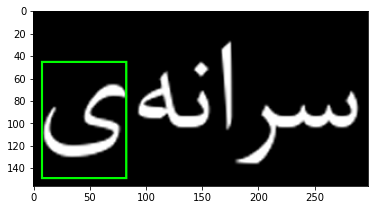

ﺮ: %99.95


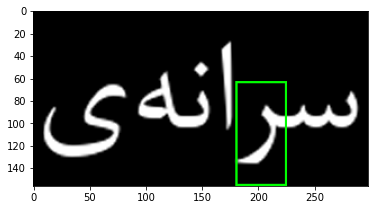

ﺳ: %99.95


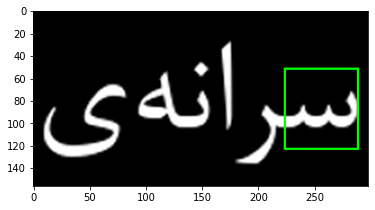

ﻧ: %99.94


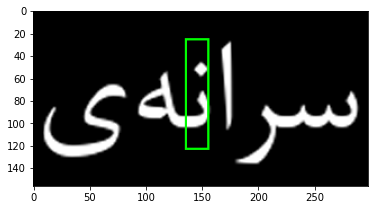

ﻪ: %99.89


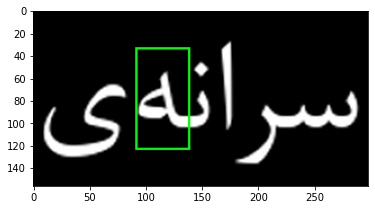

ﻟ: %93.93


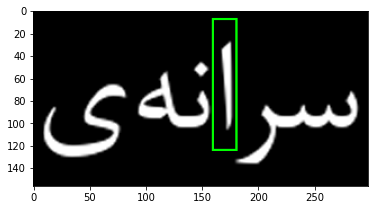

['ﺮ', 'ﺎ', 'ﻗ', 'ﻂ', 'ﻢ']
ﺮ: %99.97


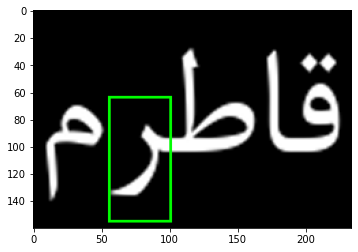

ﺎ: %99.93


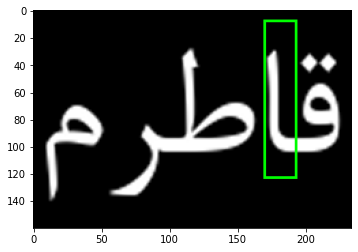

ﻗ: %99.89


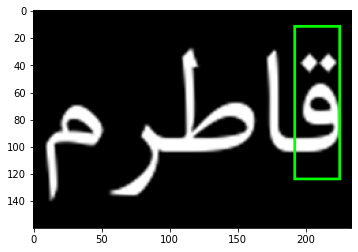

ﻂ: %99.74


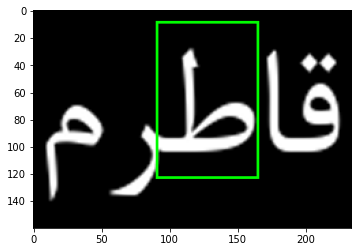

ﻢ: %64.44


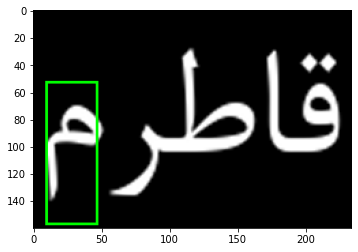

['ﺪ', 'ﻮ', 'ﻩ', 'ﮔ', 'ﯾ', 'ﻐ']
ﺪ: %99.96


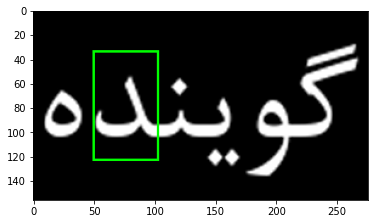

ﻮ: %99.94


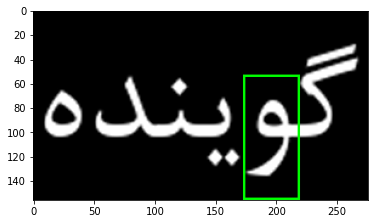

ﻩ: %99.91


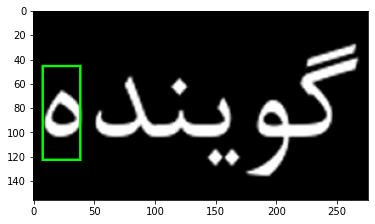

ﮔ: %99.91


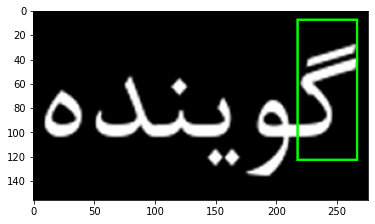

ﯾ: %99.79


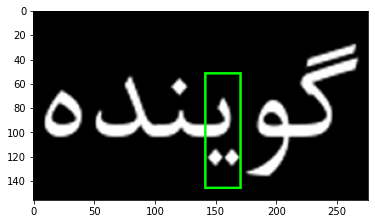

ﻐ: %96.66


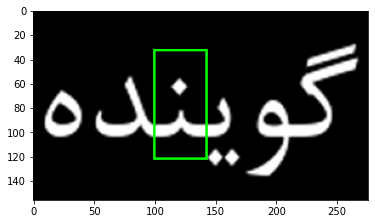

['ﻪ', 'ﻋ', 'ﻬ', 'ﻣ', 'ﻐ', 'ﻐ']
ﻪ: %99.94


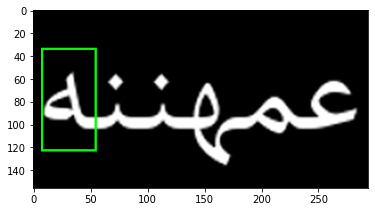

ﻋ: %99.94


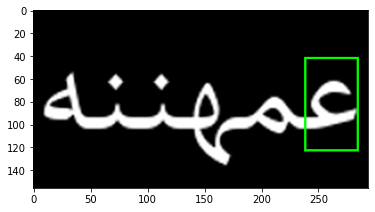

ﻬ: %99.93


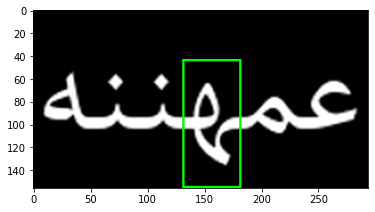

ﻣ: %99.63


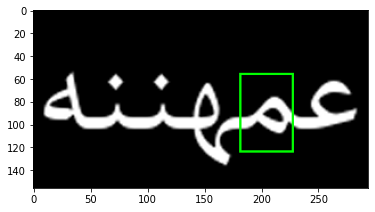

ﻐ: %98.11


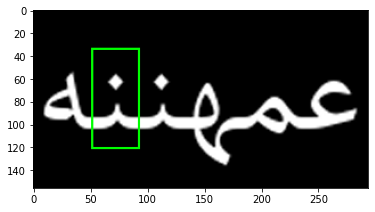

ﻐ: %97.65


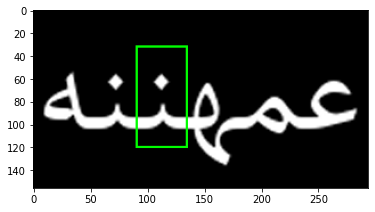

['ﺎ', 'ﺎ', 'ﻣ', 'ﻮ', 'ﻣ', 'ﻧ', 'ﻘ']
ﺎ: %99.99


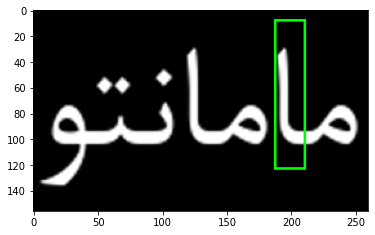

ﺎ: %99.97


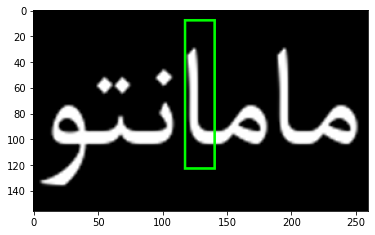

ﻣ: %99.95


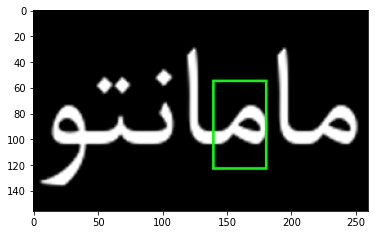

ﻮ: %99.93


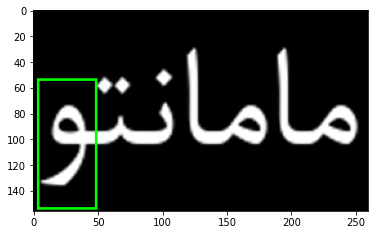

ﻣ: %99.93


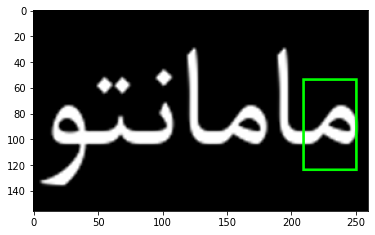

ﻧ: %99.5


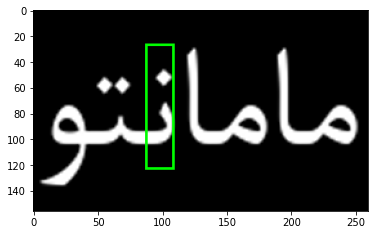

ﻘ: %62.65


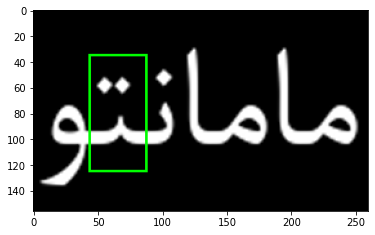

['ﺎ', 'ﻬ', 'ﻮ', 'ﺳ', 'ﭼ', 'ﺮ', 'ﻢ']
ﺎ: %99.98


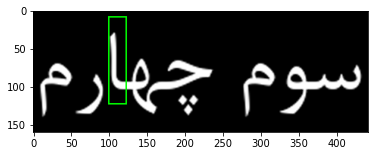

ﻬ: %99.97


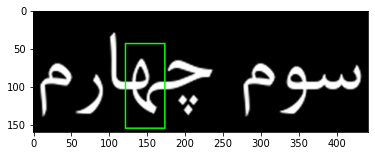

ﻮ: %99.96


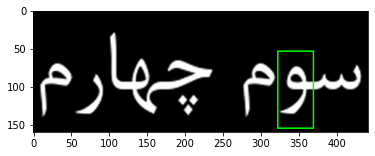

ﺳ: %99.94


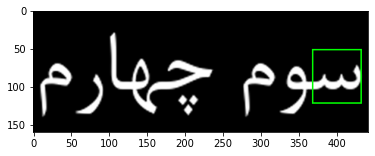

ﭼ: %99.94


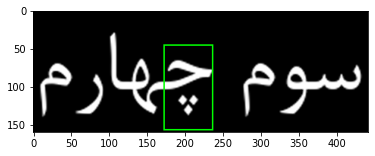

ﺮ: %99.83


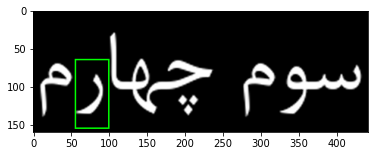

ﻢ: %65.38


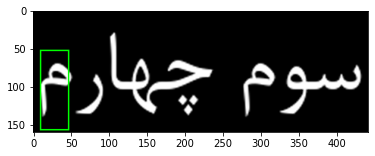

['ﻞ', 'ﻛ', 'ﻠ', 'ﭘ', 'ﻐ', 'ﻐ']
ﻞ: %99.95


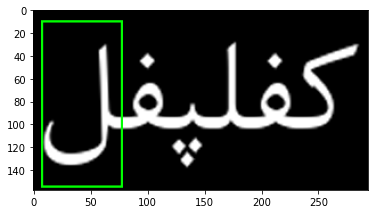

ﻛ: %99.92


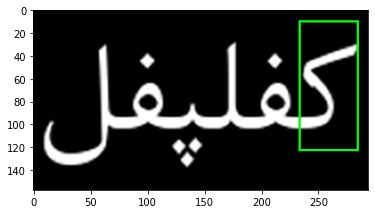

ﻠ: %99.91


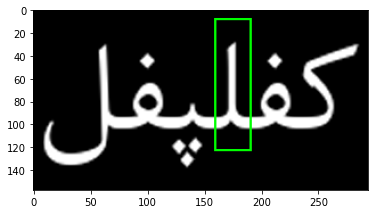

ﭘ: %97.76


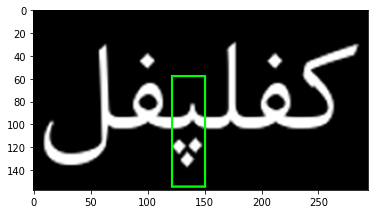

ﻐ: %61.89


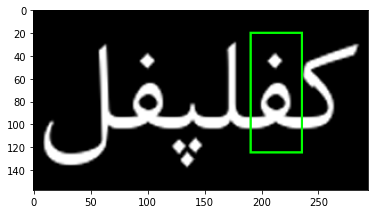

ﻐ: %60.64


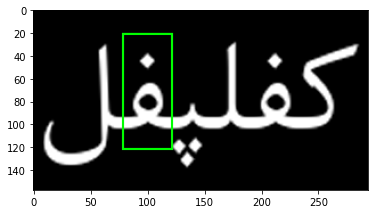

['ﻛ', 'ﺮ', 'ﯾ']
ﻛ: %99.97


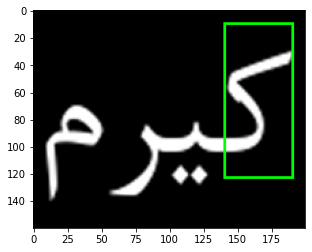

ﺮ: %99.96


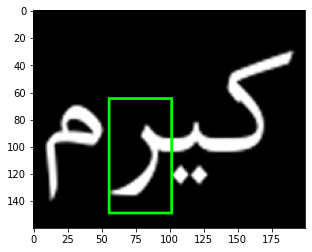

ﯾ: %92.13


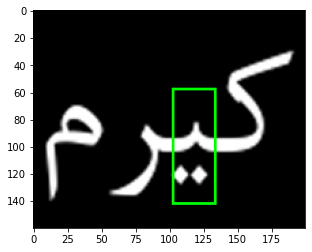

['ﺮ', 'ﺳ', 'ﻢ', 'ﻘ']
ﺮ: %99.96


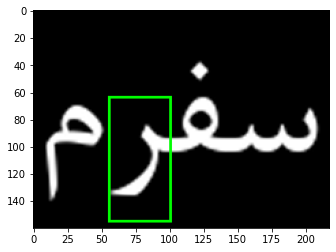

ﺳ: %99.92


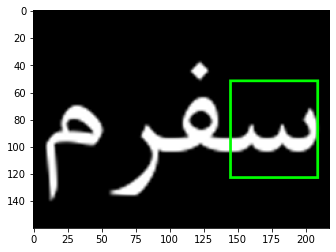

ﻢ: %64.49


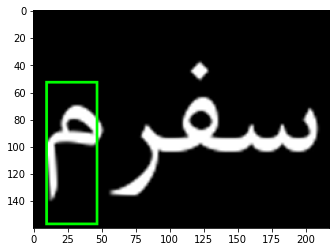

ﻘ: %63.39


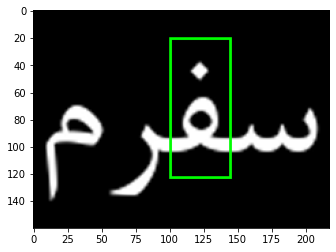

In [ ]:
from pathlib import Path
images = Path(r'/content/TestDataset_n')
predict(images, sensetivity=0.6, visualizing=True)

Using the Pridictor of Detectron, basically does the same as above, but better.

In [ ]:
from detectron2.engine.defaults import DefaultPredictor

dete_predictor = DefaultPredictor(cfg)

In [ ]:
input = cv2.imread(img_path)
output = dete_predictor(input)
output

{'instances': Instances(num_instances=100, image_height=78, image_width=80, fields=[pred_boxes: Boxes(tensor([[6.2923e+01, 2.5889e+01, 6.7939e+01, 3.1358e+01],
         [6.3040e+01, 2.6034e+01, 6.7921e+01, 3.1163e+01],
         [6.3612e+01, 2.6645e+01, 6.7163e+01, 2.8957e+01],
         [5.0253e+01, 4.1780e+01, 5.2133e+01, 4.4937e+01],
         [6.2918e+01, 2.6275e+01, 6.7980e+01, 3.0767e+01],
         [5.0208e+01, 4.1809e+01, 5.2049e+01, 4.5132e+01],
         [6.2985e+01, 2.6072e+01, 6.7836e+01, 3.1092e+01],
         [5.0364e+01, 4.1830e+01, 5.2169e+01, 4.4882e+01],
         [6.3111e+01, 2.5848e+01, 6.7742e+01, 3.0893e+01],
         [6.3091e+01, 2.5902e+01, 6.8104e+01, 3.0886e+01],
         [4.4457e-01, 0.0000e+00, 1.4246e+01, 5.3987e+01],
         [6.3521e+01, 2.7384e+01, 6.7169e+01, 2.9580e+01],
         [6.3651e+01, 2.6745e+01, 6.7140e+01, 2.8884e+01],
         [6.3415e+01, 2.7480e+01, 6.7083e+01, 2.9778e+01],
         [4.0048e-01, 0.0000e+00, 1.5211e+01, 5.4182e+01],
         [6.33

randomly selecting several samples to visualize the prediction results. (working on it)

In [ ]:
from detectron2.utils.visualizer import ColorMode


test_dicts = conv2dete("/content/val_images", "val_ocr.json")

for instance in random.sample(test_dicts, 3):
    im_frame = Image.open(instance["file_name"])
    np_frame = np.array(im_frame)
    img = np.expand_dims(np_frame, axis=2)
    print(img.shape)
    print(instance["height"], instance["width"])

    img = cv2.imread(instance["file_name"])
    #img = np.expand_dims(np_frame, axis=2)
    
    output = predictor(img)
    print(output)
    v = Visualizer(img[:, :, ::-1],
                  metadata=ocr_metadata, 
                  scale=0.5,
                  instance_mode=ColorMode.IMAGE_BW
    )
    outimg = v.draw_instance_predictions(output["instances"].to("cpu"))
    cv2_imshow(outimg.get_image()[:, :, ::-1])

TypeError: ignored

/content/val_images/image0.png
(58, 145)
58 145


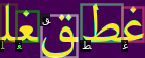

In [ ]:
# dataset_dicts = conv2dete("/content/train_images", "train_ocr.json", train_label_map)
dataset_dicts = conv2dete("/content/val_images", "val_ocr.json", val_label_map)
    
for instance in dataset_dicts:
    im_frame = Image.open(instance["file_name"])
    np_frame = np.array(im_frame)
    img = np.expand_dims(np_frame, axis=2)
    img = img.squeeze()
    print(instance["file_name"])
    print(img.shape)
    print(instance["height"], instance["width"])
    # img = imageio.imread(instance["file_name"])
    visualizer = Visualizer(img[:, :], metadata=ocr_metadata, scale=1)
    out = visualizer.draw_dataset_dict(instance)
    cv2_imshow(out.get_image()[:, :, ::-1])
    break

In [ ]:
! ls

sample_data


In [ ]:
def sort_word(word):
    word_sort = []
    for i in range(len(word)):
        already_sorted = True
        for j in range(len(word) - i - 1):
            x = word[j]['bbox'][0]
            x_next = word[j + 1]['bbox'][0]
            if x > x_next:
                word_sort[j], word_sort[j + 1] = word[j + 1], word[j]
                already_sorted = False
        if already_sorted:
            break
    return word_sort[::-1]

In [ ]:
import json

def read_output(jfile):
    with open(jfile, 'r') as f:
        file = f.read()
        jdump = json.loads(file)
    return jdump

In [ ]:
evaluator = COCOEvaluator("ocr_val", cfg, False, output_dir="./output/")

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

def predict():
    evaluator = COCOEvaluator("ocr_val", cfg, False, output_dir="./output/")
    mapper = DatasetMapper(cfg, is_train=False, augmentations=[])
    val_loader = build_detection_test_loader(cfg, "ocr_val", mapper=mapper)
    print(inference_on_dataset(trainer.model, val_loader, evaluator))